In [1]:
from scipy.io import loadmat
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = loadmat('reaction_diffusion_big.mat')

In [3]:
U = data['u'].reshape((512*512, 201)) # columns are snapshot of the reaction

In [4]:
# fig = plt.figure(figsize=(10,5))
# fig.subplots_adjust(hspace=0.4, wspace=0.4)
# r = [2, 10, 20, 50, 100,200]

# for i in range(1, 7):
#     ax = fig.add_subplot(2, 3, i)
#     reconstimg = np.matrix(u[:, :r[i-1]]) * np.diag(s[:r[i-1]]) * np.matrix(v[:r[i-1], :])
#     ax.imshow(reconstimg[:,0].reshape(512,512))
#     title = 'r=' + str(r[i-1])
#     ax.title.set_text(title)

## Reaction-diffusion System:  
1. first project to a low-dimensional subspace via the SVD
2. see how forecasting works in the low-rank variables.

In [5]:
def get_training_data(X, plot=False, r=2):
    
    # SVD on target matrix
    u,s,v = np.linalg.svd(X,full_matrices=0) 
    
    ur = u[:, :r]
    Xr = ur.T.dot(X)
    
    x = Xr[:,:-1]
    y = Xr[:,1:]
    
    x_train = x[:,:160]
    y_train = y[:,:160]
    
    x_test  = x[:,160:]
    y_test  = y[:,160:] 
    
    if plot:
        plot_subspace(X, ur)
    
    return ur, x_train, y_train, x_test, y_test

In [6]:
def plot_subspace(X, ur):

    Xr = ur.T.dot(X)
    
    mpl.rcParams['legend.fontsize'] = 10

    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    z = Xr[1]
    x = range(201)
    y = Xr[0]
    ax.plot(x, y, z,'-bo')
    ax.set_xlabel('Time')
    ax.set_ylabel('Mode 1')
    ax.set_zlabel('Mode 2')

    plt.title('Projection onto first two mode subpace through time')
    plt.show()


In [7]:
ur, x_train, y_train, x_test, y_test = get_training_data(U)

In [8]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(2, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'], validation_split=0.2)
nn = model.fit(x_train.T, y_train.T, epochs=100, batch_size=16)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
160/160 [==============================] - 0s 1ms/step - loss: 66850.8633 - acc: 0.4125
Epoch 2/100
160/160 [==============================] - 0s 56us/step - loss: 58009.9781 - acc: 0.5438
Epoch 3/100
160/160 [==============================] - 0s 50us/step - loss: 51067.3848 - acc: 0.7188
Epoch 4/100
160/160 [==============================] - 0s 56us/step - loss: 45039.9715 - acc: 0.8625
Epoch 5/100
160/160 [==============================] - 0s 56us/step - loss: 39345.7727 - acc: 0.8750
Epoch 6/100
160/160 [==============================] - 0s 50us/step - loss: 33607.2445 - acc: 0.8812
Epoch 7/100
160/160 [==============================] - 0s 50us/step - loss: 27800.7279 - acc: 0.9000
Epoch 8/100
160/160 [==============================] - 0s 50us/step - loss: 21973.8768 - acc: 0.9187
Epoch 9/100
160/160 [==============================] - 0s 50us/step - los

160/160 [==============================] - 0s 50us/step - loss: 5.1777 - acc: 1.0000
Epoch 78/100
160/160 [==============================] - 0s 50us/step - loss: 5.2235 - acc: 1.0000
Epoch 79/100
160/160 [==============================] - 0s 56us/step - loss: 5.2020 - acc: 1.0000
Epoch 80/100
160/160 [==============================] - 0s 56us/step - loss: 5.0158 - acc: 1.0000
Epoch 81/100
160/160 [==============================] - 0s 50us/step - loss: 4.8150 - acc: 1.0000
Epoch 82/100
160/160 [==============================] - 0s 50us/step - loss: 4.7932 - acc: 1.0000
Epoch 83/100
160/160 [==============================] - 0s 50us/step - loss: 4.7871 - acc: 1.0000
Epoch 84/100
160/160 [==============================] - 0s 50us/step - loss: 4.6432 - acc: 1.0000
Epoch 85/100
160/160 [==============================] - 0s 50us/step - loss: 4.6442 - acc: 1.0000
Epoch 86/100
160/160 [==============================] - 0s 50us/step - loss: 4.4802 - acc: 1.0000
Epoch 87/100
160/160 [===========

Text(0, 0.5, 'loss')

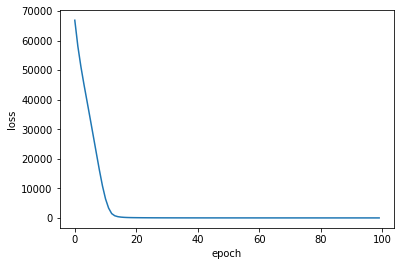

In [9]:
plt.plot(nn.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')

In [10]:
y_pred = np.zeros(y_test.shape)

In [11]:
x0 = x_test.T[0]
cur = x0

for i in range(y_pred.shape[1]):
    pred = model.predict(cur.reshape(1,-1))
    y_pred[:,i] = pred
    cur = pred

In [21]:
img_pred = ur.dot(y_pred)
img_recon = ur.dot(y_test)
img_original = U[:,160:200]

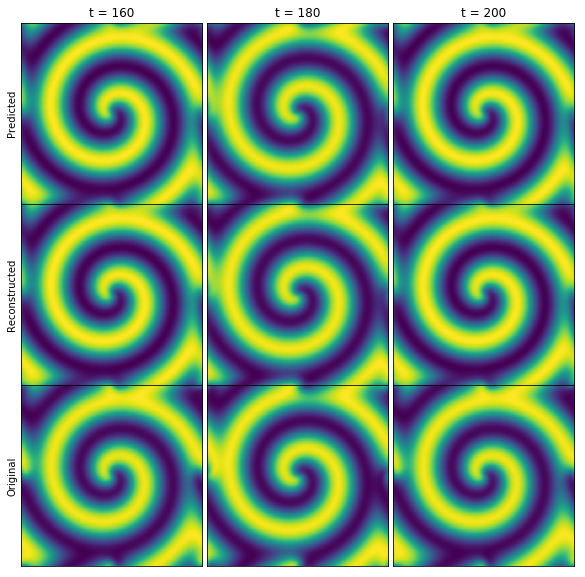

In [56]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
fig.subplots_adjust(wspace=0, hspace=0)

idx = [0, 20, 40]
title = ['t = 160', 't = 180', 't = 200']
for i in range(3):
    ax[0][i].imshow(img_pred[:,idx[i]-1].reshape(512,512))
    ax[0][i].set_xticks(()); ax[0][i].set_yticks(())
    ax[0][i].set_title(title[i])
    ax[0][0].set_ylabel('Predicted')
    ax[1][i].imshow(img_recon[:,idx[i]-1].reshape(512,512))
    ax[1][i].set_xticks(()); ax[1][i].set_yticks(())
    ax[1][0].set_ylabel('Reconstructed')
    ax[2][i].imshow(img_original[:,idx[i]-1].reshape(512,512))
    ax[2][i].set_xticks(()); ax[2][i].set_yticks(())
    ax[2][0].set_ylabel('Original')
    
